# Dimensionality Reduction with Tumor Classification Tasks

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Tumor Image Detection

Let's imagine we have a tumor dataset, where a tumor is an image with a big blog in the center. Let's say the computation time on the images is killing us, and we want to know if we can get the same performance, but somehow compress the image. How can we do that?

To tackle this problem, let's first create a tumor dataset

In [4]:
#This takes a position grid and a center and returns an image of a tumor
def create_tumor(pos, center):
    rv = multivariate_normal(center)
    tumor = rv.pdf(pos)
    return tumor

In [9]:
x,y = np.mgrid[0:100, 0:100]

In [12]:
x

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       ..., 
       [97, 97, 97, ..., 97, 97, 97],
       [98, 98, 98, ..., 98, 98, 98],
       [99, 99, 99, ..., 99, 99, 99]])

In [16]:
pos = np.empty(x.shape + (2,))
pos[:,:,0] = x
pos[:,:,1] = y
pos.shape

(100, 100, 2)

In [18]:
image = create_tumor(pos, [49.5, 49.5])

<matplotlib.contour.QuadContourSet instance at 0x111a29200>

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


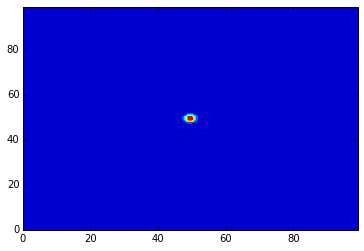

In [19]:
plt.contourf(x,y,image)

In [22]:
#This will create some noise on our image to make it seem realistic
def generate_noise(size, scale):
    return np.random.normal(scale=scale,size=size)

<matplotlib.contour.QuadContourSet instance at 0x1130f01b8>

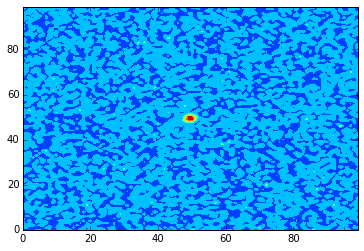

In [32]:
noise = generate_noise(100**2, scale=.01)
plt.contourf(x,y,image+noise.reshape(100,100))

## Testing a basic algorithm

Now that we can create some images, let's see how well different algorithms deal with our classification task. We'll start off by generating 1000 images

In [160]:
img_size = 64
num_images = 5000
X = pd.DataFrame(np.random.normal(scale=0.1,size=(num_images,img_size**2)))
y = np.zeros(num_images)

x1, x2 = np.mgrid[0:img_size, 0:img_size]
pos = np.empty(x1.shape + (2,))
pos[:,:,0] = x1
pos[:,:,1] = x2
tumor = create_tumor(pos, [31.5, 31.5]).reshape(img_size**2)

X[::2] += tumor
y[::2] = 1

<matplotlib.contour.QuadContourSet instance at 0x11f206ea8>

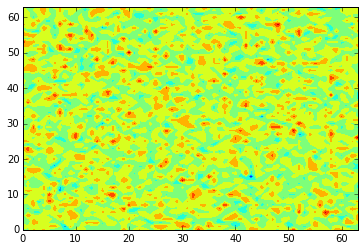

In [161]:
plt.contourf(x1,x2, X.iloc[0,:].reshape(img_size,img_size))

In [186]:
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [187]:
#let's break up the dataset into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [188]:
clf = SGDClassifier()
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.99280000000000002

In [189]:
clf.score(X_test, y_test)

0.80479999999999996

In [190]:
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, y_train)
clf2.score(X_train,y_train)

1.0

In [191]:
clf2.score(X_test, y_test)

0.8024

In [192]:
clf3 = RandomForestClassifier()
clf3.fit(X_train, y_train)
clf3.score(X_train, y_train)

0.99280000000000002

In [193]:
clf3.score(X_test, y_test)

0.69279999999999997

## Reducing the dimension of the data

We now have a basic benchmark for model performance. How will reducing the dimension of the data hurt us in our prediction?

In [194]:
from sklearn.decomposition import PCA

In [195]:
#takes about a minute
X_train, X_test, y_train, y_test = train_test_split(X, y)
pca = PCA()
X_train_pca = pca.fit(X_train)

In [196]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

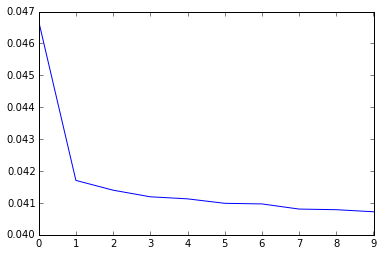

In [197]:
plt.plot(pca.explained_variance_[0:10])

<matplotlib.contour.QuadContourSet instance at 0x127390830>

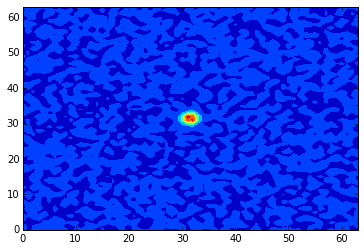

In [198]:
plt.contourf(x1,x2,pca.components_[0].reshape(img_size,img_size))

In [199]:
num_components = 1
clf_l2 = SGDClassifier()
clf_l2.fit(X_train_pca[:,:num_components],y_train)
clf_l2.score(X_train_pca[:,:num_components], y_train)

0.82613333333333339

In [200]:
clf_l2.score(X_test_pca[:,:num_components], y_test)

0.81679999999999997

In [201]:
clf_d2 = DecisionTreeClassifier()
clf_d2.fit(X_train_pca[:,:num_components], y_train)
clf_d2.score(X_train_pca[:,:num_components], y_train)

1.0

In [202]:
clf_d2.score(X_test_pca[:,:num_components], y_test)

0.72240000000000004

## How does performance change as the number of components changes?

In [104]:
results = []

for k in range(1,200):
    clf_L2 = SGDClassifier()
    clf_L2.fit(X_train_pca[:,:k],y_train)
    
    results.append(clf_L2.score(X_test_pca[:,:k], y_test))

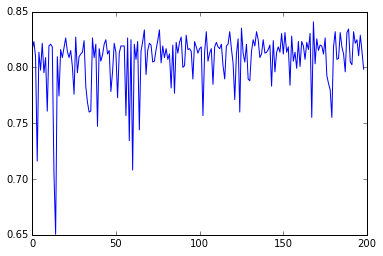

In [105]:
plt.plot(results)

In [106]:
from sklearn.preprocessing import StandardScaler

pca_full = PCA(n_components=25)
ss = StandardScaler()
ss.fit(X_train)
X_train_pca = pca_full.fit_transform(ss.transform(X_train))
X_test_pca = pca_full.transform(ss.transform(X_test))

In [107]:
results_full = []
for k in range(1,25):
    clf_full = SGDClassifier()
    clf_full.fit(X_train_pca[:,:k], y_train)
    
    results_full.append(clf_full.score(X_test_pca[:,:k], y_test))
    
    

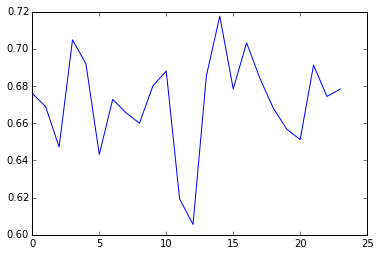

In [108]:
plt.plot(results_full)

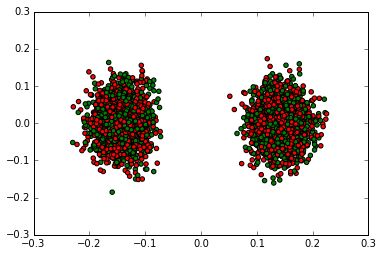

In [185]:
cmap = {0:'g', 1: 'r'}
plt.scatter(X_train_pca[:,0], X_train_pca[:,1],c=[cmap[x] for x in y_train])

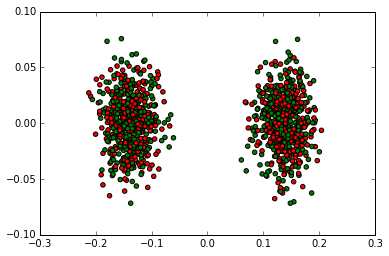

In [184]:
plt.scatter(X_test_pca[:,0], X_test_pca[:,1],c=[cmap[x] for x in y_test])

## Another dimensionality reduction algorithm is called Partial Least Squares (PLS)

This algorithm looks to find vectors that best explain the cross-covariance: the relationship between both the Xs and the ys.

In [132]:
from sklearn.cross_decomposition import PLSRegression


In [173]:
pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [174]:
X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)

In [177]:
results_pls = []

for k in range(1,20):
    clf_l2 = SGDClassifier()
    clf_l2.fit(X_train_pls[:,:k],y_train)
    
    results_pls.append(clf_l2.score(X_test_pls[:,:k], y_test))

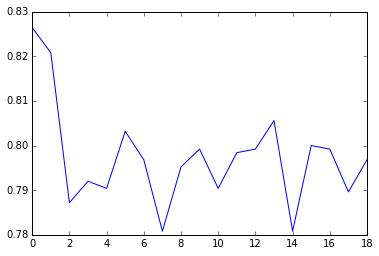

In [178]:
plt.plot(results_pls)

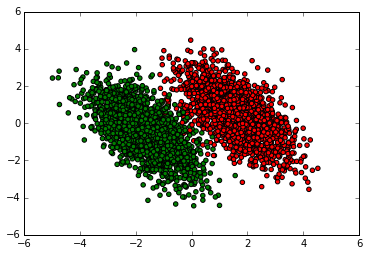

In [183]:
plt.scatter(X_train_pls[:,0], X_train_pls[:,1],c=[cmap[x] for x in y_train])